# Explaining notes:

# Explanation of this demo:
   - The point cloud script produces a point cloud on the 3-torus $\mathbb{T}^3$, when it's embedded in $\mathbb{R}^6$
   - Then the Delaunay triangulation script creates a simplicial decomposition of it 
   - The Mesh Laplacian script ("Mesh" here being a stand-in for simplicial decomposition) then produces the eigendecomposition of the Mesh Laplacian according to the nD cotangent formula (paper by Keenan Crane)
   - I have then used the package called geometric kernels (link to paper about the matern gaussian processes neurips paper) but altered it to handle meshes of dimensions (a trivial fix since the dimension only changes the scale factor we apply to the Liouville-whatever decomp of our kernel)
   - The demo below is not mathematically rigorous but it shows that the kernel adequately approximates geodesic distance along the hypertorus to a decent amount. This is despite it not even knowing that the point cloud lies on a hypertorus . Note that the produced plotly plot is more for intuition than pure rigour since it's a 3D plot of a 6D space and thus meaningless.  




Contents of this ipynb:
- Doing BO on the mesh. Showing with two different BO loops (and then plotting the posterior mu_1, mu_2 functions respectively). You can tweak the number of iterations that each do 
- Visualisation of the kernel spreading covariance throughout the shape. 

## Importing everything

In [1]:

%pip install -e "../Altered packages/GeometricKernels" numpy scipy matplotlib plotly kaleido

import numpy as np
import random
from scipy.stats import norm
import geometric_kernels
from geometric_kernels.spaces import Mesh
from geometric_kernels.kernels import MaternGeometricKernel, MaternKarhunenLoeveKernel
import matplotlib as mpl
import matplotlib.pyplot as plt
import kaleido
import plotly
import plotly.io as pio
pio.renderers.default = "browser" # "browser" opens in browser. "vscode" in vscode (for the notebook version; doesn't work with py) 
from pathlib import Path
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from Plotting import *

Obtaining file:///workspaces/Newest-try-/Altered%20packages/GeometricKernels
  Installing build dependencies ... -

done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for geometric_kernels (pyproject.toml) ... done
  Created wheel for geometric_kernels: filename=geometric_kernels-0.4-py3-none-any.whl size=8835 sha256=84623443072de2c554826b98dc0c7530ef53b187429818cdb5c3ace0f4c02adc
  Stored in directory: /tmp/pip-ephem-wheel-cache-yj3xhuan/wheels/a3/88/0f/62cc36c2f8a5adcb8e307bac8051fd1078533735e772aadd33
Successfully built geometric_kernels
  Attempting uninstall: geometric_kernels
    Found existing installation: geometric_kernels 0.4
    Uninstalling geometric_kernels-0.4:
      Successfully uninstalled geometric_kernels-0.4
Note: you may need to restart the kernel to use updated packages.


INFO (geometric_kernels): Numpy backend is enabled. To enable other backends, don't forget to `import geometric_kernels.*backend name*`.
INFO (geometric_kernels): We may be suppressing some logging of external libraries. To override the logging policy, call `logging.basicConfig`.
/usr/local/python/3.12.1/lib/python3.12/site-packages/spherical_harmonics/fundamental_set.py:21: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


## Mesh and kernel set up

In [2]:
MeshFolder_dir = Path.cwd() #/ "My meshes"
print( "DIR:", MeshFolder_dir)
Filename = "6D_TORUS_OBJ_FILE.obj"
BULLSHIT_MESH = Mesh.load_mesh(str(MeshFolder_dir / Filename))
print(BULLSHIT_MESH.num_vertices)



from geometric_kernels.spaces.eigenfunctions import EigenfunctionsFromEigenvectors
eigenvals = np.load("6D_TORUS_EIGENVALS.npy").reshape(-1,1)
eigenvectors = np.load("6D_TORUS_EIGENVECS.npy") # N x D  where N = num eigenvectors and D = "degree" (not sure what they mean)



num_verts = BULLSHIT_MESH.num_vertices
whole_domain = np.atleast_2d(np.arange(1, num_verts + 1)).T

eigenfunctions = EigenfunctionsFromEigenvectors(eigenvectors = eigenvectors)
kernel = MaternKarhunenLoeveKernel(space = BULLSHIT_MESH,
                                          eigenfunctions = eigenfunctions,
                                          eigenvalues_laplacian = eigenvals,
                                          num_levels = eigenvectors.shape[0],
                                          dimension = 6,
                                          normalize = True)




#Kernel stuff:
#kernel = MaternGeometricKernel(BULLSHIT_MESH)

LENGTH_SCALE,NU = 0.3, 0.4
VARIANCE = "NEEDS_CONFIGURING"  #variance isn't part of the package but it can be "easily implemented" by multiplying the kernel by a constant and then optimising for it





DIR: /workspaces/Newest-try-/6D_Demo
150


## Objective functions (choose one)


In [3]:
params = kernel.init_params()
params["lengthscale"] = np.array([LENGTH_SCALE])
params["nu"] = np.array([NU])

# TRYOUT

In [4]:
Tryout = kernel.K(params, whole_domain - 1 , whole_domain - 1 )


In [5]:


def f(x):
    #assuming that x is a node index.
    if isinstance(x, np.ndarray): euclidean_coord =  BULLSHIT_MESH.vertices[np.int64(x.flatten()) -1].flatten()
    else:
        euclidean_coord = BULLSHIT_MESH.vertices[x-1]
    return euclidean_coord[0]
    # return np.array(3)
j = np.vectorize(f)

## BO setup

In [6]:
def expected_improvement(mu, sigma, f_best, xi=0.0):
    """
    Calculates the Expected Improvement (EI) for a set of points.

    Args:
        mu (np.ndarray): The posterior mean vector.
        sigma (np.ndarray): The posterior standard deviation vector.
        f_best (float): The best observed function value.
        xi (float): The exploration-exploitation trade-off parameter.

    Returns:
        np.ndarray: The EI vector.
    """
    # Calculate the standardized improvement (Z)
    xi = 0.9
    with np.errstate(divide='ignore'):  # suppress divide by zero warning
        
        mu = mu.reshape(-1,1) # TODO: delete this if it causes issues. 
        sigma = sigma.reshape(-1,1)
        Z = (f_best - mu - xi) / sigma #TODO: this and the one below may be the wrong expression. 
        
    # Calculate the EI for non-zero sigma
    ei = (f_best - mu - xi) * norm.cdf(Z) + sigma * norm.pdf(Z)
    
    # Handle the case where sigma is zero
    ei = np.where(sigma > 1e-10, ei, 0.0)
    
    return ei


def BO_loop_fixed(num_iterations, x_obs=None, objective_func=None, 
                  exploration_weight=0.1):
    """
    Fixed BO loop with better exploration of inner torus surface.
    
    Args:
        exploration_weight: Add random exploration with this probability
    """
    if objective_func is None:
        objective_func = f
    if x_obs is None:
        x_obs = x_observed

    num_verts = BULLSHIT_MESH.num_vertices
    whole_domain = np.atleast_2d(np.arange(1, num_verts + 1)).T

    y_observed = np.atleast_2d(np.apply_along_axis(objective_func, 1, x_obs)).reshape(-1, 1)
    K_XX_prior = kernel.K(params, whole_domain - 1, whole_domain - 1)
    mu_prior_vector = np.zeros((num_verts, 1))

    exploration_points = []

    for i in range(num_iterations):
        # GP Model Fitting
        m_vector = mu_prior_vector[x_obs.flatten() - 1]
        K_xX = kernel.K(params, x_obs - 1, whole_domain - 1)
        K_xx = kernel.K(params, x_obs - 1, x_obs - 1)
        K_Xx = K_xX.T
        
        K_xx_stable = K_xx + np.eye(K_xx.shape[0]) * 1e-6
        C_inv = np.linalg.pinv(K_xx_stable)

        mew_vec = mu_prior_vector + K_Xx @ C_inv @ (y_observed - m_vector)
        Current_K_matrix = K_XX_prior - K_Xx @ C_inv @ K_xX
        Sigma_vec = np.diag(Current_K_matrix).copy().reshape(-1, 1)
        Sigma_vec[Sigma_vec < 0] = 0 

        # Acquisition Function
        EI_vec = expected_improvement(mew_vec, np.sqrt(Sigma_vec), np.min(y_observed))
        
        
        next_point = np.argmax(EI_vec) + 1
        
        next_point = np.atleast_2d(next_point)

        # Update
        y_next = np.atleast_2d(objective_func(next_point - 1))
        x_obs = np.vstack((x_obs, next_point))
        y_observed = np.vstack((y_observed, y_next))

    
    return mew_vec, Sigma_vec, EI_vec, x_obs, y_observed

## Plot to show kernel geometry-awareness

In [7]:
def visualize_kernel_influence(mesh, kernel, params, source_point, objective_vals):
    """
    Visualize how much influence a single point has across the mesh.
    """
    source_idx = np.atleast_2d([source_point])
    all_points = np.atleast_2d(np.arange(mesh.num_vertices)).T
    
    # Compute kernel values from source to all points
    params["lengthscale"] = params["lengthscale"] 
    K_influence = kernel.K(params, source_idx, all_points).flatten()
    
    # Create visualization
    fig = go.Figure()
    
    # Plot kernel influence
    influence_trace = vector_values_to_mesh_trace(
        mesh, K_influence,
        marker=dict(colorscale='Viridis', colorbar=dict(title="Kernel Value"))
    )
    influence_trace = add_custom_hover_data(influence_trace, customdata = K_influence.reshape(-1,1))
    fig.add_trace(influence_trace)
    
    # Mark source point
    source_coord = mesh.vertices[source_point]
    j_trace = go.Scatter3d(
        x=[source_coord[0]], y=[source_coord[1]], z=[source_coord[2]],
        mode='markers',
        marker=dict(size=15, color='red', symbol='diamond'),
        name='Source Point'
    )

    j_trace = add_custom_hover_data(j_trace, customdata = K_influence.reshape(-1, 1))

    fig.add_trace(j_trace)
    

    
    fig.update_layout(title=f"Kernel Influence from Point {source_point}")
    return fig

initial_point = np.array([[4]]) - 1
influence_fig = visualize_kernel_influence(
    BULLSHIT_MESH, kernel, params, 
    initial_point.item(), objective_vals
)
fig_show(influence_fig)

NameError: name 'objective_vals' is not defined

# new section:


### Creating general geodesic-kernel plot

#### So look at the initial point cloud and find the kernels inbetween them based on this poisson mesh discretisation (using nearest distance) and then the actual continuous kernel based on the geometric kernels package

In [8]:
poisson_mesh_points = BULLSHIT_MESH.vertices #N x 3 matrix. 
# riginal_mesh_points = np.empty((0, 3), dtype = np.float32) # N x 3 matrix 

In [9]:
original_mesh_points = np.load("6D_TORUS_POINT_CLOUD.npy")


In [10]:
num_verts = BULLSHIT_MESH.num_vertices

def find_nearest_poisson(original_point):
    min_dist = 10000
    best_one = False
    for node_ind in range(BULLSHIT_MESH.num_vertices):
        poisson_point = original_mesh_points[node_ind, :]
        if np.linalg.norm(poisson_point - original_point)<min_dist: #GONNA NEED SOME DEBUGGING
            min_dist = np.linalg.norm(poisson_point - original_point)
            best_one = node_ind
    return best_one

#make the bastard mesh kernel

INDS_VECTOR = np.zeros((original_mesh_points.shape[0], 1))

for i in range(original_mesh_points.shape[0]):
    
    point_1 = original_mesh_points[i, :]
    
    INDS_VECTOR[i] = find_nearest_poisson(point_1)
BASTARD_KERNEL_MATRIX = kernel.K(params, INDS_VECTOR , INDS_VECTOR)

print(BASTARD_KERNEL_MATRIX)



[[0.04642643 0.04183497 0.04222674 ... 0.04278575 0.04346372 0.04225158]
 [0.04183497 0.04478693 0.04022009 ... 0.04315849 0.04316751 0.04353129]
 [0.04222674 0.04022009 0.04472368 ... 0.04173268 0.04159335 0.0412754 ]
 ...
 [0.04278575 0.04315849 0.04173268 ... 0.04451314 0.04455756 0.04239524]
 [0.04346372 0.04316751 0.04159335 ... 0.04455756 0.04478683 0.04211937]
 [0.04225158 0.04353129 0.0412754  ... 0.04239524 0.04211937 0.0446028 ]]


###### Distances matrix

In [11]:
from geometric_kernels.spaces import Hypersphere
from geometric_kernels.spaces import Circle, ProductDiscreteSpectrumSpace

proper_cts_torus = ProductDiscreteSpectrumSpace(Circle(), Circle())

# cts_kernel = MaternGeometricKernel(proper_cts_torus, num = 100)
cts_kernel = MaternGeometricKernel(proper_cts_torus)
Dist_matrix = np.zeros((original_mesh_points.shape[0], original_mesh_points.shape[0]))
original_mesh_points = original_mesh_points
CTS_kernel_matrix = cts_kernel.K(params, original_mesh_points, original_mesh_points)

verts = BULLSHIT_MESH.vertices #N x 3


for i in range(original_mesh_points.shape[0]):
    for j in range(i, original_mesh_points.shape[0]):
        point_1 = original_mesh_points[i]
        point_2 = original_mesh_points[j]
        if i % 10 == 0: print(point_1 )
        
        geodesic_dist = np.linalg.norm(point_1 - point_2)
        Dist_matrix[j][i] = geodesic_dist
        Dist_matrix[i][j] = geodesic_dist




        

print(CTS_kernel_matrix)

        


[-0.96323392 -0.26866415 -0.24123015  0.97046794  0.91409598 -0.4054979 ]
[-0.96323392 -0.26866415 -0.24123015  0.97046794  0.91409598 -0.4054979 ]
[-0.96323392 -0.26866415 -0.24123015  0.97046794  0.91409598 -0.4054979 ]
[-0.96323392 -0.26866415 -0.24123015  0.97046794  0.91409598 -0.4054979 ]
[-0.96323392 -0.26866415 -0.24123015  0.97046794  0.91409598 -0.4054979 ]
[-0.96323392 -0.26866415 -0.24123015  0.97046794  0.91409598 -0.4054979 ]
[-0.96323392 -0.26866415 -0.24123015  0.97046794  0.91409598 -0.4054979 ]
[-0.96323392 -0.26866415 -0.24123015  0.97046794  0.91409598 -0.4054979 ]
[-0.96323392 -0.26866415 -0.24123015  0.97046794  0.91409598 -0.4054979 ]
[-0.96323392 -0.26866415 -0.24123015  0.97046794  0.91409598 -0.4054979 ]
[-0.96323392 -0.26866415 -0.24123015  0.97046794  0.91409598 -0.4054979 ]
[-0.96323392 -0.26866415 -0.24123015  0.97046794  0.91409598 -0.4054979 ]
[-0.96323392 -0.26866415 -0.24123015  0.97046794  0.91409598 -0.4054979 ]
[-0.96323392 -0.26866415 -0.24123015  

Making the actual plot mi bumbaclat. 


In [12]:
c = np.zeros((original_mesh_points.shape[0] ** 2, 1)) #Real distances matrix (Geodesics)
b = np.zeros_like(c) #proper cts kernel 
a = np.zeros_like(c) #bastard mesh one

for i in range(0, original_mesh_points.shape[0]):
    for j in range(0, original_mesh_points.shape[0]):
        c[(original_mesh_points.shape[0])*i + j] = Dist_matrix[i][j]
        b[(original_mesh_points.shape[0])*i + j] = CTS_kernel_matrix[i][j]
        a[(original_mesh_points.shape[0])*i + j] = BASTARD_KERNEL_MATRIX[i][j]




## Trying to plot this shit

In [13]:
'''
import numpy as np
import matplotlib.pyplot as plt



# Ensure data is 1D for plotting (flattening the column vectors)
c = c.flatten()
a = a.flatten()
b = b.flatten()

# 1. Create figure and primary Axes (ax1)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Set the primary plot (a vs c) on the left Y-axis
color_a = 'tab:red'
ax1.set_xlabel('Vector c (X-axis)')
ax1.set_ylabel('Vector a (Y1)', color=color_a)
ax1.scatter(c, a, c=color_a, label='Vector a', s = 3)
ax1.tick_params(axis='y', labelcolor=color_a)

# 2. Create secondary Axes (ax2) sharing the X-axis
ax2 = ax1.twinx()

# Set the secondary plot (b vs c) on the right Y-axis
color_b = 'tab:blue'
ax2.set_ylabel('Vector b (Y2)', color=color_b)
ax2.scatter(c, b, c=color_b, label='Vector b', s = 3)
ax2.tick_params(axis='y', labelcolor=color_b)


#TRYING TO FIX THE SCALING ISSUES:



# 3. Add title and legend
plt.title('Scatter Plots with Dual Y-Axes')
# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# 4. Show plot
plt.show() 
#BOTH DATASETS HAVE BEEN NORMALSIED SO THE ACTUAL NUMBERS ARE MEANINGLESS 
'''

"\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n\n\n# Ensure data is 1D for plotting (flattening the column vectors)\nc = c.flatten()\na = a.flatten()\nb = b.flatten()\n\n# 1. Create figure and primary Axes (ax1)\nfig, ax1 = plt.subplots(figsize=(10, 6))\n\n# Set the primary plot (a vs c) on the left Y-axis\ncolor_a = 'tab:red'\nax1.set_xlabel('Vector c (X-axis)')\nax1.set_ylabel('Vector a (Y1)', color=color_a)\nax1.scatter(c, a, c=color_a, label='Vector a', s = 3)\nax1.tick_params(axis='y', labelcolor=color_a)\n\n# 2. Create secondary Axes (ax2) sharing the X-axis\nax2 = ax1.twinx()\n\n# Set the secondary plot (b vs c) on the right Y-axis\ncolor_b = 'tab:blue'\nax2.set_ylabel('Vector b (Y2)', color=color_b)\nax2.scatter(c, b, c=color_b, label='Vector b', s = 3)\nax2.tick_params(axis='y', labelcolor=color_b)\n\n\n#TRYING TO FIX THE SCALING ISSUES:\n\n\n\n# 3. Add title and legend\nplt.title('Scatter Plots with Dual Y-Axes')\n# Combine legends from both axes\nlines1, labels1 =

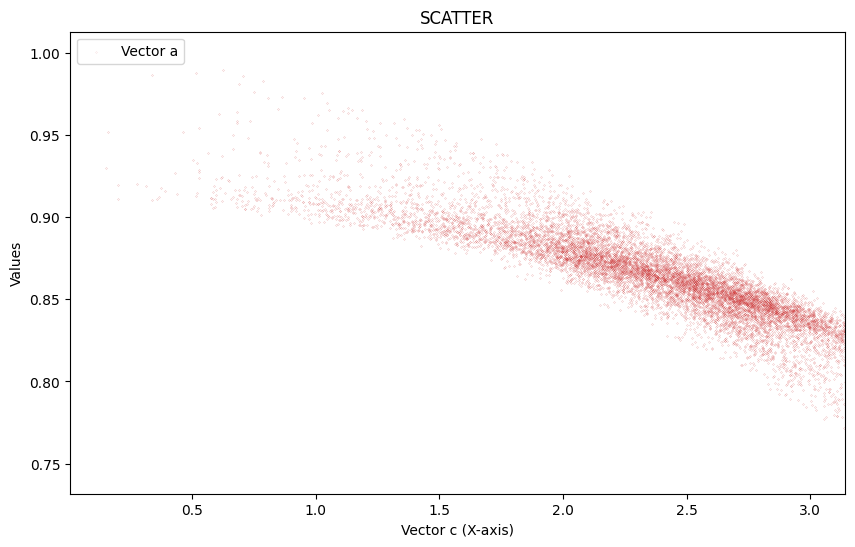

(22500,)


In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure data is 1D for plotting (flattening the column vectors)
c = c.flatten()
a = a.flatten() 
b = b.flatten()


a = a * (1/ np.max(a))

# 1. Create figure and Axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot both datasets on the same axis
ax1.set_xlabel('Vector c (X-axis)')
ax1.set_xlim(0.005, 3.1415)
ax1.set_ylabel('Values', color='black')  # Single y-axis label for both datasets
ax1.scatter(c, a, c='tab:red', label='Vector a', s=0.003)
# ax1.scatter(c, b, c='tab:blue', label='Vector b', s=3)

# Add legend
ax1.legend(loc='upper left')


# Add title
plt.title('SCATTER')

# Show plot
plt.show()
print(c.shape)

In [15]:
J = eigenfunctions.eigenvectors
print(BULLSHIT_MESH.vertices)

[[-9.63233915e-01 -2.68664148e-01 -2.41230146e-01]
 [-1.31871247e-01 -9.91266853e-01  5.00655423e-01]
 [ 9.94379929e-01  1.05870474e-01 -8.11241483e-02]
 [-4.83618029e-01  8.75279157e-01  8.85894980e-01]
 [-6.78670738e-01  7.34442666e-01 -5.62892136e-01]
 [ 9.54296055e-01  2.98862910e-01 -1.53910091e-01]
 [ 7.91960817e-01  6.10571916e-01  9.11582998e-01]
 [ 8.18375402e-01  5.74684001e-01 -6.68703088e-01]
 [ 2.88778115e-02  9.99582949e-01  8.86047449e-01]
 [ 7.00363409e-01 -7.13786450e-01  8.51774220e-01]
 [ 9.47878633e-01  3.18631602e-01 -9.38424883e-04]
 [ 9.28658908e-01  3.70934808e-01 -9.19062647e-01]
 [ 7.06889487e-02  9.97498407e-01  3.54640230e-01]
 [ 2.86830377e-01  9.57981386e-01 -1.16069592e-01]
 [ 4.56599506e-01  8.89672351e-01  9.38129664e-01]
 [-8.61859694e-01  5.07146791e-01 -9.68865861e-01]
 [ 9.33741219e-01 -3.57948789e-01  9.93039486e-01]
 [-9.78471184e-01  2.06383484e-01  9.79879026e-01]
 [ 9.68549096e-01 -2.48822523e-01 -1.86104483e-01]
 [ 9.99999315e-01 -1.17014055e-

In [16]:
objective_vals = j(np.arange(0, BULLSHIT_MESH.num_vertices, 1))
pio.renderers.default = "browser"

objective_plot_kwargs = dict(
    name = "objective value",
    marker = dict(
        size = 10,
        colorscale = 'hot'
    )
)
objective_trace = vector_values_to_mesh_trace(BULLSHIT_MESH, objective_vals, **objective_plot_kwargs)
hover_kwargs = dict(
    customdata = np.hstack([np.atleast_2d(objective_vals).T, np.atleast_2d(np.arange(1, BULLSHIT_MESH.num_vertices + 1)).T]),
    hovertemplate = ("x : %{x:.2f}<br>" + "y : %{y:.2f}<br>" + "z : %{z:.2f}<br>" + "objective value: %{customdata[0]:.2f}<br>" + "node index: %{customdata[1]}"),
)
objective_trace = add_custom_hover_data(objective_trace, **hover_kwargs)



# plot 2 different results (posterior mean, posterior stdev, x observed, y observed) with 2 different num_iterations


initial_point = np.array ([[np.random.randint(1, BULLSHIT_MESH.num_vertices)]])
mu_1, sigma_1, ei_1, X_1, Y_1 = BO_loop_fixed(1, x_obs = initial_point, objective_func = f)
mu_2, sigma_2, ei_2, X_2, Y_2 = BO_loop_fixed(5,x_obs = initial_point,  objective_func = f)
mu_3, sigma_3, ei_3, X_3, Y_3 = BO_loop_fixed(10,x_obs = initial_point,  objective_func = f)

advanced_fig = go.Figure()

mu_1_trace = vector_values_to_mesh_trace(BULLSHIT_MESH, mu_1)
mu_2_trace = vector_values_to_mesh_trace(BULLSHIT_MESH, mu_2)
mu_3_trace = vector_values_to_mesh_trace(BULLSHIT_MESH, mu_3)
mu_2_trace = add_custom_hover_data(mu_2_trace, customdata = mu_2)
mu_1_trace = add_custom_hover_data(mu_1_trace, customdata = mu_1)
mu_3_trace = add_custom_hover_data(mu_3_trace, customdata = mu_3)

advanced_fig.add_trace(mu_1_trace)
advanced_fig.add_trace(mu_2_trace)
advanced_fig.add_trace(mu_3_trace)
advanced_fig.add_trace(objective_trace)




####plotting the points explored by the algoritjm

euclidean_coord_of_point_plotted = BULLSHIT_MESH.vertices[np.int64(X_2.flatten()-1)]
third_euclidean_coord_of_point_plotted = BULLSHIT_MESH.vertices[np.int64(X_3.flatten()-1)]
point_plot_trace = go.Scatter3d(
    x = np.array(euclidean_coord_of_point_plotted[:,0]),
    y = np.array(euclidean_coord_of_point_plotted[:,1]),
    z = np.array(euclidean_coord_of_point_plotted[:,2]),
    marker = dict(
        color = "cyan"
    ),
    mode = "markers"
)

second_point_plot_trace = go.Scatter3d(
    x = np.array(third_euclidean_coord_of_point_plotted[:,0]),
    y = np.array(third_euclidean_coord_of_point_plotted[:,1]),
    z = np.array(third_euclidean_coord_of_point_plotted[:,2]),
    marker = dict(
        color = "purple"
    ),
    mode = "markers"
)

advanced_fig.add_trace(point_plot_trace)
advanced_fig.add_trace(second_point_plot_trace)



fig_show(advanced_fig) #TODO: add this back

print("the sampled values are (sorted ascending)", sorted(list(Y_2)), ".While the true best is", np.min(objective_vals), "which is at index:", np.argmax(-1*objective_vals))
print("the initial point's value is", objective_vals[initial_point.squeeze()])

TypeError: 'int' object is not callable

# Manipulating the plot:
In each visualisation, there are "traces" which are basically like "axes" in numpy. You can click each to show/hide them. The objective one is the objective function visualised on the mesh and the trace 1 and trace 2 are the posterior means predicted by the GP's

## BO